In [1]:
import torch
import torch.utils.data
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms.v2 as v2
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from tqdm import tqdm
from PIL import Image, ImageOps

import torch.nn as nn
from pathlib import Path

import models.MathNet as mnt
import models.MathNet20 as mnt20
import models.MathNet112 as mnt112

In [2]:
BATCH_SIZE = 160
EPOCHS = 31
IMAGE_SIZE = 224

In [3]:
def add_contrast(x):
    return transforms.functional.adjust_contrast(x, 14.5)

In [4]:
def add_padding(x):
    return transforms.functional.pad(x, IMAGE_SIZE//2 - x.size[0] // 2, 255.0, 'constant')

In [5]:
# the training transforms
train_transform = transforms.Compose([
    transforms.Grayscale(1),
    # v2.RandomApply(
    # torch.nn.ModuleList([
    #     v2.RandomResize(IMAGE_SIZE//2, IMAGE_SIZE+100),
    #     v2.Pad(12, 255., 'constant'),]), 
    #     p=0.3)
    # ,
    #add_padding,
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
    
])
# the validation transforms
valid_transform = v2.Compose([
    v2.Grayscale(1),
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.ToTensor()
])

e:\Programs\Anaconda3\envs\MyPyTorch\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [6]:
dataset = torchvision.datasets.ImageFolder(r'G:\\TRAIN\images_contrast_to'+str(IMAGE_SIZE), transform=train_transform)
print(len(dataset))

135116


In [7]:
classes_dict = dataset.class_to_idx
classes = []
for key in classes_dict.keys():
    classes.append(str(key))
classes.sort()
classes

['(',
 ')',
 '+',
 '-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 'A',
 'C',
 'F',
 'I-',
 'alpha',
 'and',
 'beta',
 'delta',
 'equal',
 'exists',
 'forall',
 'gamma',
 'lambda',
 'mu',
 'not',
 'omega',
 'or',
 'phi',
 'pi',
 'psi',
 'rightarrow',
 'sigma',
 'tau',
 'theta',
 'upsilon',
 'x',
 'y',
 'z',
 'Г']

In [8]:
# classes = ['(', ')', ',', '-', 
#                    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
#                    'A', '[', 'α', 'and', 'β', '∃', 'F', '∀', 
#                    'γ', 'λ', 'μ', 'ω', 'or', 'φ', '→', 
#                    'σ', 'sqrt', 'θ', 'v', 'x', 'y', 'z']

NUM_CLASSES = len(classes)

def map_pred(ind):
    if ind < NUM_CLASSES:
        return classes[ind]
    return 'ERROR MAPPIMG'

NUM_CLASSES

44

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
device

device(type='cuda', index=0)

In [10]:
mean, std = dataset[0][0].mean(), dataset[0][0].std()
print(mean, std)

tensor(0.9714) tensor(0.1641)


In [11]:
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(
        list(range(len(dataset))), 
        test_size=val_split,
        stratify=dataset.targets,
        )
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [12]:
datasets = train_val_dataset(dataset)
print(type(datasets['train']))
print(len(datasets['val']))
# The original dataset is avail


<class 'torch.utils.data.dataset.Subset'>
27024


In [13]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 135116
    Root location: G:\\TRAIN\images_contrast_to224
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )


27024
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]) torch.Size([1, 224, 224])


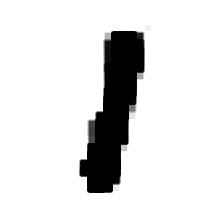

In [14]:
# training dataset
train_dataset = datasets['train']
# validation dataset
valid_dataset = (datasets['val'])
# training data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=6, pin_memory=True
)
# validation data loaders
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=6, pin_memory=True
)
# training data loaders

train_dataset
print(len(valid_dataset))
print(valid_dataset[15551][0], valid_dataset[15551][0].shape)
#print(valid_dataset.dataset.targets)
aaa = v2.ToPILImage()
display(aaa(valid_dataset.dataset[16000][0]))

In [15]:
from collections import Counter
#train_classes = [label for _, label in valid_dataset]
#Counter(train_classes)
train_classes = [dataset.targets[i] for i in train_dataset.indices]
valid_classes = [dataset.targets[i] for i in valid_dataset.indices]
print(Counter(train_classes))
print(Counter(valid_classes))


Counter({34: 2845, 21: 2717, 30: 2686, 29: 2673, 33: 2658, 41: 2645, 17: 2630, 35: 2629, 15: 2621, 25: 2621, 19: 2605, 42: 2603, 39: 2587, 3: 2578, 23: 2578, 38: 2563, 40: 2558, 2: 2558, 27: 2551, 5: 2549, 28: 2548, 0: 2539, 1: 2539, 32: 2534, 26: 2518, 14: 2510, 16: 2495, 4: 2481, 7: 2472, 8: 2467, 10: 2467, 20: 2466, 12: 2458, 18: 2458, 11: 2429, 9: 2410, 6: 2401, 13: 2400, 31: 2352, 24: 2265, 43: 2231, 22: 1502, 36: 1470, 37: 1225})
Counter({34: 711, 21: 679, 30: 672, 29: 669, 33: 665, 41: 661, 17: 658, 35: 657, 25: 655, 15: 655, 42: 651, 19: 651, 39: 647, 23: 644, 3: 644, 38: 641, 40: 640, 2: 640, 27: 638, 28: 637, 5: 637, 1: 635, 0: 635, 32: 634, 26: 630, 14: 628, 16: 624, 4: 620, 7: 618, 20: 617, 10: 617, 8: 617, 18: 614, 12: 614, 11: 607, 9: 602, 6: 600, 13: 600, 31: 588, 24: 566, 43: 558, 22: 375, 36: 367, 37: 306})


In [16]:
d = dict(Counter(valid_dataset.dataset.targets))
print(d)

{0: 3174, 1: 3174, 2: 3198, 3: 3222, 4: 3101, 5: 3186, 6: 3001, 7: 3090, 8: 3084, 9: 3012, 10: 3084, 11: 3036, 12: 3072, 13: 3000, 14: 3138, 15: 3276, 16: 3119, 17: 3288, 18: 3072, 19: 3256, 20: 3083, 21: 3396, 22: 1877, 23: 3222, 24: 2831, 25: 3276, 26: 3148, 27: 3189, 28: 3185, 29: 3342, 30: 3358, 31: 2940, 32: 3168, 33: 3323, 34: 3556, 35: 3286, 36: 1837, 37: 1531, 38: 3204, 39: 3234, 40: 3198, 41: 3306, 42: 3254, 43: 2789}


<Axes: ylabel='Сharactrs'>

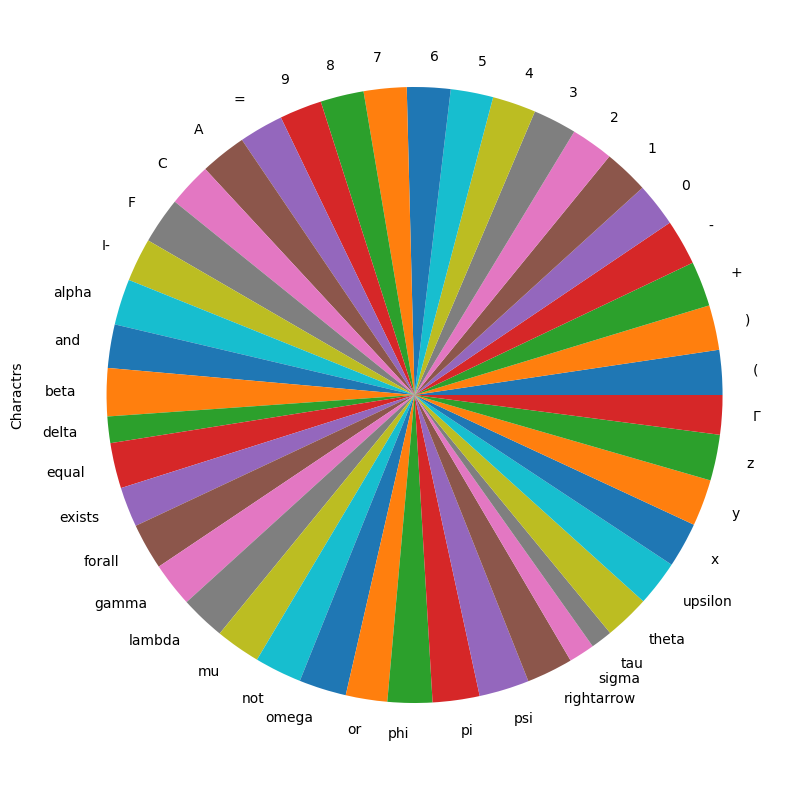

In [17]:
import pandas as pd
df = pd.Series(data=d,name='Сharactrs')    
df.plot(labels=classes,kind='pie',figsize=(10,10))

In [18]:
# for i, data in tqdm(enumerate(train_loader), total=int(len(train_loader))):
#     print(i)

In [19]:
# training
def train(model, trainloader, optimizer, loss_function):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=int(len(trainloader))):
        counter += 1
        optimizer.zero_grad()
        x, y = data
        x = x.to(device)      
        y = y.to(device)       
        outputs = model.forward(x)
        loss = loss_function(outputs, y)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == y).sum().item()
        loss.backward()
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [20]:
def validate(model, testloader, loss_function):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=int(len(testloader))):
            counter += 1
            x, y = data
            x = x.to(device)      
            y = y.to(device)
            # forward pass
            outputs = model(x)
            # calculate the loss
            loss = loss_function(outputs, y)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == y).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [21]:
if (IMAGE_SIZE == 112):
    model = mnt112.MathNet112()
elif (IMAGE_SIZE == 224):
    model = mnt.MathNet()

#model = mnt112.MathNet112()

print(mnt.NUM_CLASSES)

torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
model = model.to(device)
device
type(model)

44


models.MathNet.MathNet

In [22]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)

In [23]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, label=''):
    """
    Function to save the loss and accuracy plots to disk.
    """
    Path('outputs').mkdir(parents=True, exist_ok=True)
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/mathnet'+str(IMAGE_SIZE)+'_accuracy'+label+'.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/mathnet'+str(IMAGE_SIZE)+'_loss'+label+'.png')

In [24]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
Path('models/mathnet'+str(IMAGE_SIZE)+'/').mkdir(parents=True, exist_ok=True)
# start the training
for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                              optimizer, loss)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                 loss)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    
    torch.save(model.state_dict(), 'models/mathnet'+str(IMAGE_SIZE)+'/mathnet'+str(epoch)+'.ml')
    
# save the trained model weights
torch.save(model.state_dict(), 'models/mathnet'+str(IMAGE_SIZE)+'/mathnet.ml')
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 31
Training


100%|██████████| 676/676 [02:14<00:00,  5.01it/s]


Validation


100%|██████████| 169/169 [00:12<00:00, 13.38it/s]


Training loss: 0.398, training acc: 90.794
Validation loss: 0.133, validation acc: 96.614
--------------------------------------------------
[INFO]: Epoch 2 of 31
Training


100%|██████████| 676/676 [02:14<00:00,  5.04it/s]


Validation


100%|██████████| 169/169 [00:11<00:00, 14.70it/s]


Training loss: 0.088, training acc: 97.887
Validation loss: 0.081, validation acc: 97.850
--------------------------------------------------
[INFO]: Epoch 3 of 31
Training


KeyboardInterrupt: 

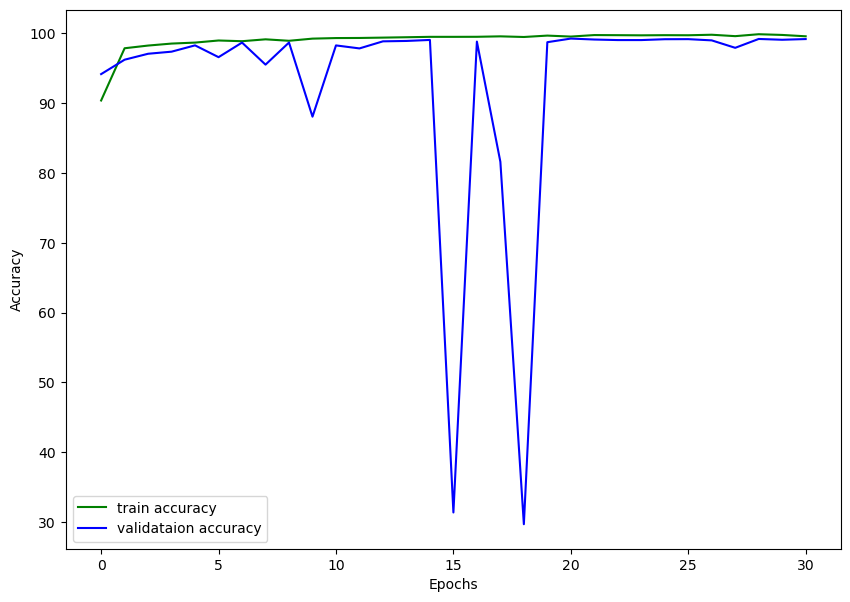

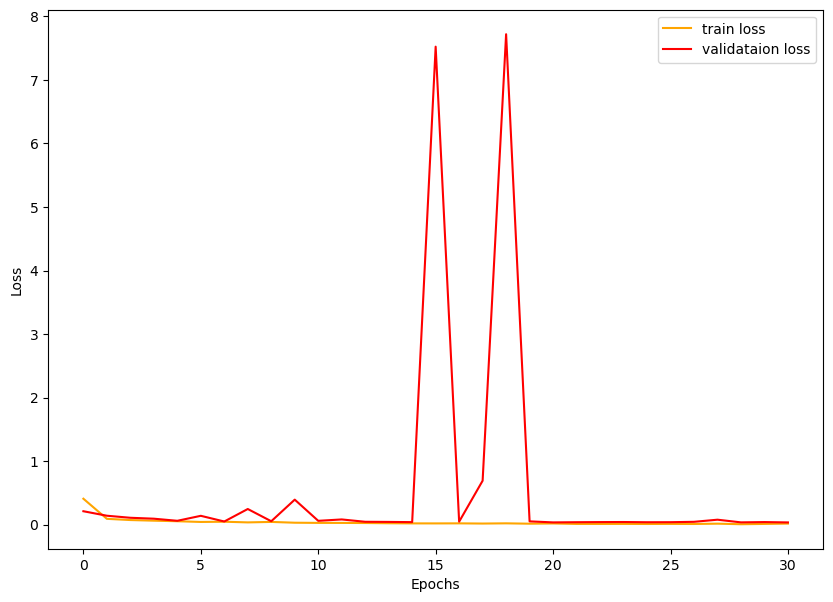

In [ ]:
save_plots(train_acc, valid_acc, train_loss, valid_loss)

e:\Programs\Anaconda3\envs\MyPyTorch\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


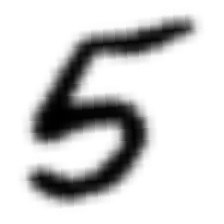

tensor([[-114.5141, -144.1559, -123.3853, -101.6058,  -66.2194, -145.0895,
         -106.8651,  -20.2239,  -75.6568,  174.7190,   10.1984, -117.4936,
          -45.4433,  -45.4203, -115.7059, -106.7613,  -88.3924,  -61.1867,
          -63.3205,  -95.4474,  -93.6929,  -69.1685,  -64.3131,  -75.2675,
          -86.0528,  -85.3085,  -78.9893, -115.5815,  -83.7699,  -78.0818,
         -108.5941, -133.1081,  -88.9201,  -36.4663,  -87.9288,  -96.9016,
            6.5587,  -49.8102, -112.6628,  -72.1734, -117.6205, -142.8175,
         -151.4684,  -27.7540]], device='cuda:0', grad_fn=<MulBackward0>) 5


In [ ]:
import cv2
from PIL import Image, ImageOps

model.eval()

img = Image.open("TEST/0.jpg")
#print(img.shape)
convert_tensor = v2.Compose([
    v2.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    v2.Grayscale(1),
    v2.ToTensor()

])        
x_image = convert_tensor(img)

aaa = v2.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = model(x_image) 
print(pred*10, mnt.map_pred(pred.argmax().item()))

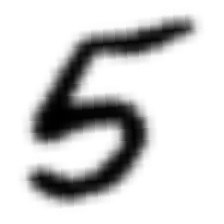

tensor([[-48.8702, -56.3684, -76.8984, -40.0630, -15.2442, -82.8647, -45.1727,
           3.5615, -38.1110, 133.0769,   2.5196, -55.2430, -32.2983,   1.6033,
         -44.2802, -58.3944, -41.3387,   9.6478, -29.2735, -48.0430, -36.4355,
         -28.4413, -28.5588, -26.3832, -46.3119, -49.8153, -48.2777, -54.5584,
         -49.4430, -34.5720, -64.7097, -58.1875, -29.5898, -22.1219, -53.5231,
         -48.3091,   0.8369, -28.3141, -57.6479, -29.2494, -63.1751, -73.1409,
         -73.0790, -10.4121]], device='cuda:0', grad_fn=<MulBackward0>) 5


In [ ]:
import cv2
from PIL import Image, ImageOps

m = mnt.MathNet()
m.load_state_dict(torch.load('T:\my_programs\Math_recognition\models\mathnet224'+'/mathnet8.ml'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
m = m.to(device)
m.eval()

img = Image.open("TEST/0.jpg")
#print(img.shape)
convert_tensor = v2.Compose([
    v2.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    v2.Grayscale(1),
    v2.ToTensor()

])        
x_image = convert_tensor(img)

aaa = v2.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = m(x_image) 
print(pred*10, mnt.map_pred(pred.argmax().item()))